In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
from qutip import *
import itertools as it
import copy
from qiskit.providers.fake_provider import FakeCairo, FakeBelem
from qiskit.quantum_info import random_clifford

In [2]:
# import functions from stomp_functions.py
import stomp_functions as stf

In [3]:
def rel_norm_diff(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.linalg.norm(a - b) / np.linalg.norm(a)

In [4]:
# Define system parameters
N = 3
g = 1
J = 1

In [5]:
# Set up beta values and step size
beta = 0.1
num_steps = 100
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

In [6]:
# Construct tensored lists of pauli x and z for creating hamiltonian
z_ops, x_ops = stf.construct_op_lists(N)

In [7]:
# Construct the Hamiltonian
# Loop over sites to construct parts of H
H_qis = 0
for n in range(N-1):
    H_qis += -J * z_ops[n] @ z_ops[n+1]
    for m in range(N):
        H_qis += -J * g * x_ops[n]

# Get eigenenergies from H
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

In [8]:
# Create registers
qr = QuantumRegister(N)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)

# Define initial wavefunction
#init_wf = [1 / np.sqrt(2**N) for i in range(2**N)]
init_wf = [0 for i in range(2 ** N)]
init_wf[0] = 1

# Create random clifford operator
cliff = random_clifford(N, seed=87)

init_wf = cliff.to_matrix() @ np.array(init_wf)

In [9]:
# Define number of shots to use and backend for circuits
num_shots = 1*8192
#backend = Aer.get_backend('aer_simulator')
backend = FakeBelem()

In [10]:
# Perform hadamard estimation to get overlaps
he_circs_re = stf.hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, dt, cliff)

In [11]:
he_circs_im = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, dt, cliff)

In [12]:
ovlps_r = stf.get_ovlps(he_circs_re, backend, num_shots)

In [13]:
ovlps_i = stf.get_ovlps(he_circs_im, backend, num_shots)

In [14]:
ovlps = ovlps_r + 1j * ovlps_i

In [15]:
# Perform Pauli decomposition on H
pauli_H = stf.pauli_string_decomp(H_qis, nq=N)
print(pauli_H)

{'III': 0j, 'IIX': 0j, 'IIY': 0j, 'IIZ': 0j, 'IXI': (-24+0j), 'IXX': 0j, 'IXY': 0j, 'IXZ': 0j, 'IYI': 0j, 'IYX': 0j, 'IYY': 0j, 'IYZ': 0j, 'IZI': 0j, 'IZX': 0j, 'IZY': 0j, 'IZZ': (-8+0j), 'XII': (-24+0j), 'XIX': 0j, 'XIY': 0j, 'XIZ': 0j, 'XXI': 0j, 'XXX': 0j, 'XXY': 0j, 'XXZ': 0j, 'XYI': 0j, 'XYX': 0j, 'XYY': 0j, 'XYZ': 0j, 'XZI': 0j, 'XZX': 0j, 'XZY': 0j, 'XZZ': 0j, 'YII': 0j, 'YIX': 0j, 'YIY': 0j, 'YIZ': 0j, 'YXI': 0j, 'YXX': 0j, 'YXY': 0j, 'YXZ': 0j, 'YYI': 0j, 'YYX': 0j, 'YYY': 0j, 'YYZ': 0j, 'YZI': 0j, 'YZX': 0j, 'YZY': 0j, 'YZZ': 0j, 'ZII': 0j, 'ZIX': 0j, 'ZIY': 0j, 'ZIZ': 0j, 'ZXI': 0j, 'ZXX': 0j, 'ZXY': 0j, 'ZXZ': 0j, 'ZYI': 0j, 'ZYX': 0j, 'ZYY': 0j, 'ZYZ': 0j, 'ZZI': (-8+0j), 'ZZX': 0j, 'ZZY': 0j, 'ZZZ': 0j}


In [16]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_i = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps, dt,
                                                 cliff)
        
        H_circs_i[key] = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps,
                                                                   dt, cliff)

In [17]:
# Get real part of H expectations
H_ovlps_re = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re += pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [18]:
# Get imag part of H expectations
H_ovlps_im = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im += 1j * pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [19]:
# Get total H expectation
total_H_ovlp = H_ovlps_re + H_ovlps_im

In [32]:
# Classical calculation
class_ovlp, class_H_ovlp = stf.classical_calc(init_wf, H_qis.to_matrix(), 
                                              H_qis.to_matrix(), num_steps, dt)

1.0098416195649593


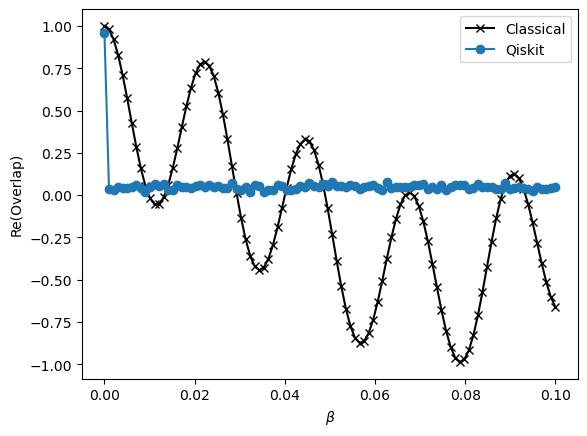

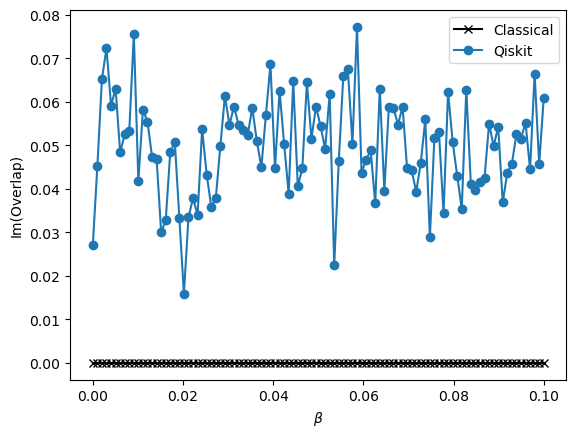

In [33]:
plt.plot(betas, np.array(class_ovlp).real, 'kx-', label='Classical')
plt.plot(betas, np.array(ovlps).real, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Re(Overlap)")
plt.legend(numpoints=1)
plt.savefig("ovlp_re_N=" + str(N) + "_numsteps=" + str(num_steps) + "_essex_1.png",
           format='png', dpi=300)

plt.figure(2)
plt.plot(betas, np.array(class_ovlp).imag, 'kx-', label='Classical')
plt.plot(betas, np.array(ovlps).imag, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Im(Overlap)")
plt.legend(numpoints=1)
plt.savefig("ovlp_im_N=" + str(N) + "_numsteps=" + str(num_steps) + "_essex_1.png",
           format='png', dpi=300)
print(np.linalg.norm(np.array(class_ovlp) - np.array(ovlps)) / 
      np.linalg.norm(np.array(class_ovlp)))

In [22]:
np.mean(ovlps)

(0.056396484375+0.049663085937500004j)

1.0034955668319576


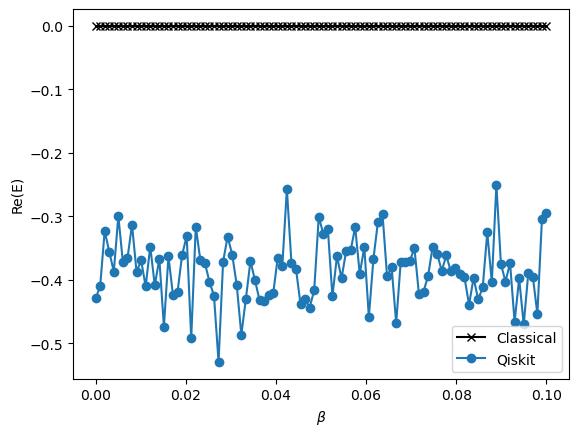

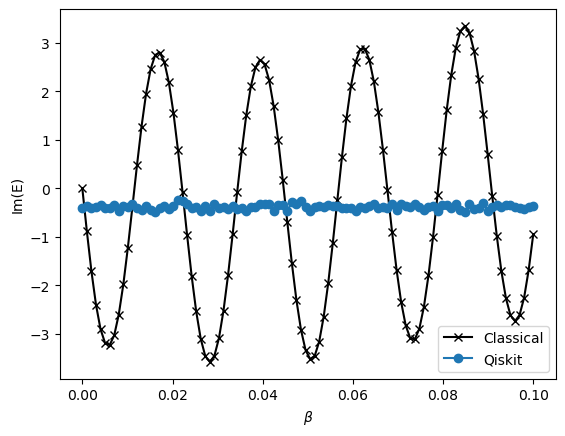

In [35]:
plt.plot(betas, np.array(class_H_ovlp).real, 'kx-', label='Classical')
plt.plot(betas, np.array(total_H_ovlp).real, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)
plt.savefig("<E>_re_N=" + str(N) + "_numsteps=" + str(num_steps) + "_essex_1.png",
           format='png', dpi=300)

plt.figure(2)
plt.plot(betas, class_H_ovlp.imag, 'kx-', label='Classical')
plt.plot(betas, total_H_ovlp.imag, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)
plt.savefig("<E>_im_N=" + str(N) + "_numsteps=" + str(num_steps) + "_essex_1.png",
           format='png', dpi=300)

print(rel_norm_diff(class_H_ovlp, total_H_ovlp))

In [24]:
# Create colormap
colors = plt.cm.jet(np.linspace(0, 1, len(E_qis[::2])+2))

In [25]:
print(E_qis)

[-6.25130259 -6.25130259 -0.95979996 -0.95979996  0.95979996  0.95979996
  6.25130259  6.25130259]


/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


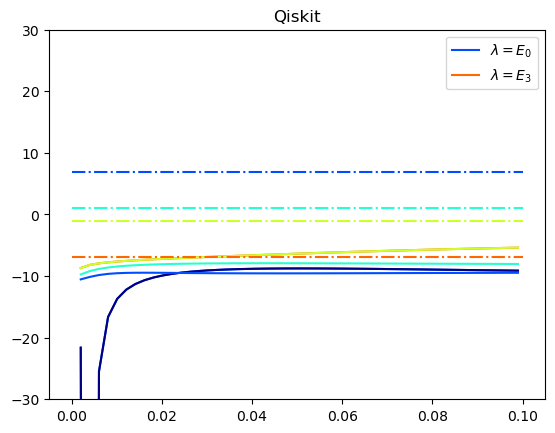

In [26]:
l = 0
for e in E_qis[::2]:
    e = -1.1*e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    plt.ylim([-30, 30])
    l += 1
    
plt.legend()
plt.title("Qiskit")
plt.savefig("fp_lambda_energies_qiskit_N=" + str(N) + "_steps=" + str(num_steps) + 
            "num_shots=" + str(num_shots) + ".png",
            format='png', dpi=300)

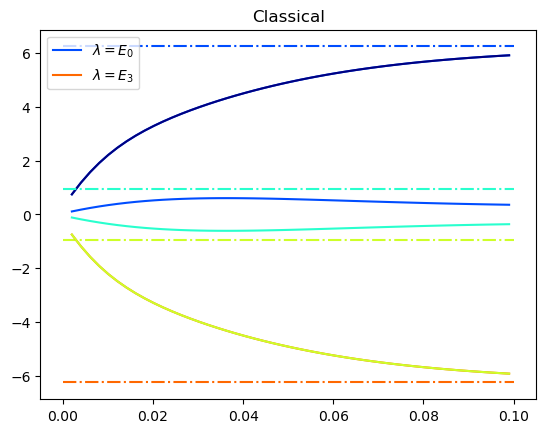

In [27]:
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.partition_calc(class_ovlp, class_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.partition_calc(class_ovlp, class_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
    
plt.legend()
plt.title("Classical")
plt.savefig("lambda_energies_classical_N=" + str(N) + "_steps=" + str(num_steps) + 
            "num_shots=" + str(num_shots) + ".png",
            format='png', dpi=300)

In [28]:
lambdas = np.linspace(-1.1 * abs(E_qis[0]), 1 * abs(E_qis[0]), 100)
calculated_energies = [stf.partition_calc(ovlps, total_H_ovlp, num_steps, _, dt)[1][-1]
                      for _ in lambdas]

Text(0.5, 0, '$\\lambda/|E_0|$')

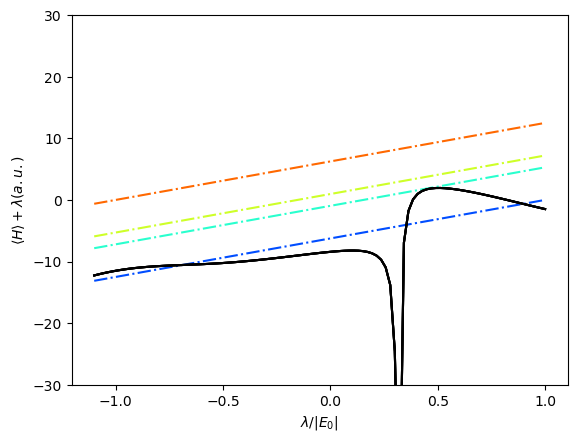

In [29]:
h = 0
for temp in E_qis[::2]:
    plt.plot(lambdas/abs(E_qis[0]), temp * np.ones(lambdas.shape[0]) + lambdas,
            '-.', color=colors[h+1])
    h += 1
    plt.plot(lambdas/abs(E_qis[0]), calculated_energies, 'k')
    plt.ylim([-30, 30])
    
plt.ylabel("$\\langle H \\rangle + \\lambda (a.u.)$")
plt.xlabel("$\\lambda/|E_0|$")

In [30]:
E_qis

array([-6.25130259, -6.25130259, -0.95979996, -0.95979996,  0.95979996,
        0.95979996,  6.25130259,  6.25130259])

Text(0.5, 0, '$\\lambda/|E_0|$')

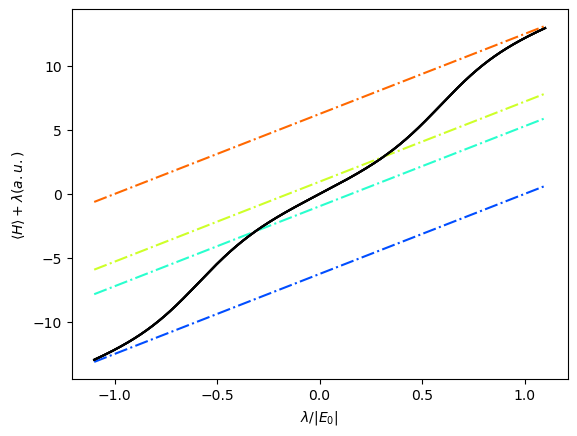

In [36]:
lambdas = np.linspace(-1.1 * abs(E_qis[0]), 1.1 * abs(E_qis[0]), 1000)
calculated_energies = [stf.partition_calc(class_ovlp, class_H_ovlp, num_steps, _, dt)[1][-1]
                      for _ in lambdas]

h = 0
for temp in E_qis[::2]:
    plt.plot(lambdas/abs(E_qis[0]), temp * np.ones(lambdas.shape[0]) + lambdas,
            '-.', color=colors[h+1])
    h += 1
    plt.plot(lambdas/abs(E_qis[0]), calculated_energies, 'k')
    
plt.ylabel("$\\langle H \\rangle + \\lambda (a.u.)$")
plt.xlabel("$\\lambda/|E_0|$")